In [13]:
# Script 2: Main Analysis - Theta Component Extraction
import numpy as np
import mne
from scipy import signal, linalg

# Load the simulated EEG data
file_path = r"C:\Users\fedor\simulated_eeg_raw.fif"
raw = mne.io.read_raw_fif(file_path, preload=True)
data = raw.get_data()
srate = raw.info['sfreq']

def filterFGx(data, srate, center_freq, half_width):
    """
    Filter data around center frequency with specified bandwidth
    """
    nyq = srate/2
    lower_freq = center_freq - half_width
    upper_freq = center_freq + half_width
    b, a = signal.butter(2, [lower_freq/nyq, upper_freq/nyq], btype='band')
    return signal.filtfilt(b, a, data)

def regularize_cov(cov, reg_lambda=0.01):
    """
    Regularize covariance matrix by adding small constant to diagonal
    """
    return cov + reg_lambda * np.mean(np.diag(cov)) * np.eye(cov.shape[0])

# Theta frequency and bandwidth
theta_freq = 6
theta_width = 2.5

# Theta covariance
thetafilt = filterFGx(data, srate, theta_freq, theta_width)
thetafilt = thetafilt - np.mean(thetafilt, axis=1, keepdims=True)
thetacov = (thetafilt @ thetafilt.T) / data.shape[1]

# Broadband covariance
tmpdat = data - np.mean(data, axis=1, keepdims=True)
bbcov = (tmpdat @ tmpdat.T) / data.shape[1]

# Regularize covariance matrices
thetacov_reg = regularize_cov(thetacov)
bbcov_reg = regularize_cov(bbcov)

# GED
evals, evecs = linalg.eigh(thetacov_reg, bbcov_reg)

# Find best component
maxcomp = np.argsort(evals)
thetamap = thetacov @ evecs  # Use original (non-regularized) covariance for maps
thetamap = thetamap[:, maxcomp[-1]]

# Fix sign of map (max is positive)
maxe = np.argmax(np.abs(thetamap))
thetamap = thetamap * np.sign(thetamap[maxe])

# Theta time series component
thetacomp = thetafilt.T @ evecs[:, maxcomp[-1]]

# Fix sign based on correlation with filtered EEG
filtered_eeg = filterFGx(data[maxe, :], srate, theta_freq, theta_width)
thetacomp = thetacomp * np.sign(np.corrcoef(thetacomp, filtered_eeg)[0,1])

print("=== Theta Component Extraction ===")
print(f"Shape of theta component: {thetacomp.shape}")
print(f"Shape of theta map: {thetamap.shape}")

# Print some additional verification
print("\n=== Component Properties ===")
print(f"Number of eigenvalues: {len(evals)}")
print(f"Range of eigenvalues: {evals.min():.2f} to {evals.max():.2f}")

Opening raw data file C:\Users\fedor\simulated_eeg_raw.fif...
Isotrak not found
    Range : 0 ... 10240 =      0.000 ...    10.000 secs
Ready.
Reading 0 ... 10240  =      0.000 ...    10.000 secs...
=== Theta Component Extraction ===
Shape of theta component: (10241,)
Shape of theta map: (64,)

=== Component Properties ===
Number of eigenvalues: 64
Range of eigenvalues: 0.00 to 0.71


VISUALIZATION OF RESULTS

ValueError: DigMontage is only a subset of info. There are 64 channel positions not present in the DigMontage. The channels missing from the montage are:

['EEG000', 'EEG001', 'EEG002', 'EEG003', 'EEG004', 'EEG005', 'EEG006', 'EEG007', 'EEG008', 'EEG009', 'EEG010', 'EEG011', 'EEG012', 'EEG013', 'EEG014', 'EEG015', 'EEG016', 'EEG017', 'EEG018', 'EEG019', 'EEG020', 'EEG021', 'EEG022', 'EEG023', 'EEG024', 'EEG025', 'EEG026', 'EEG027', 'EEG028', 'EEG029', 'EEG030', 'EEG031', 'EEG032', 'EEG033', 'EEG034', 'EEG035', 'EEG036', 'EEG037', 'EEG038', 'EEG039', 'EEG040', 'EEG041', 'EEG042', 'EEG043', 'EEG044', 'EEG045', 'EEG046', 'EEG047', 'EEG048', 'EEG049', 'EEG050', 'EEG051', 'EEG052', 'EEG053', 'EEG054', 'EEG055', 'EEG056', 'EEG057', 'EEG058', 'EEG059', 'EEG060', 'EEG061', 'EEG062', 'EEG063'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

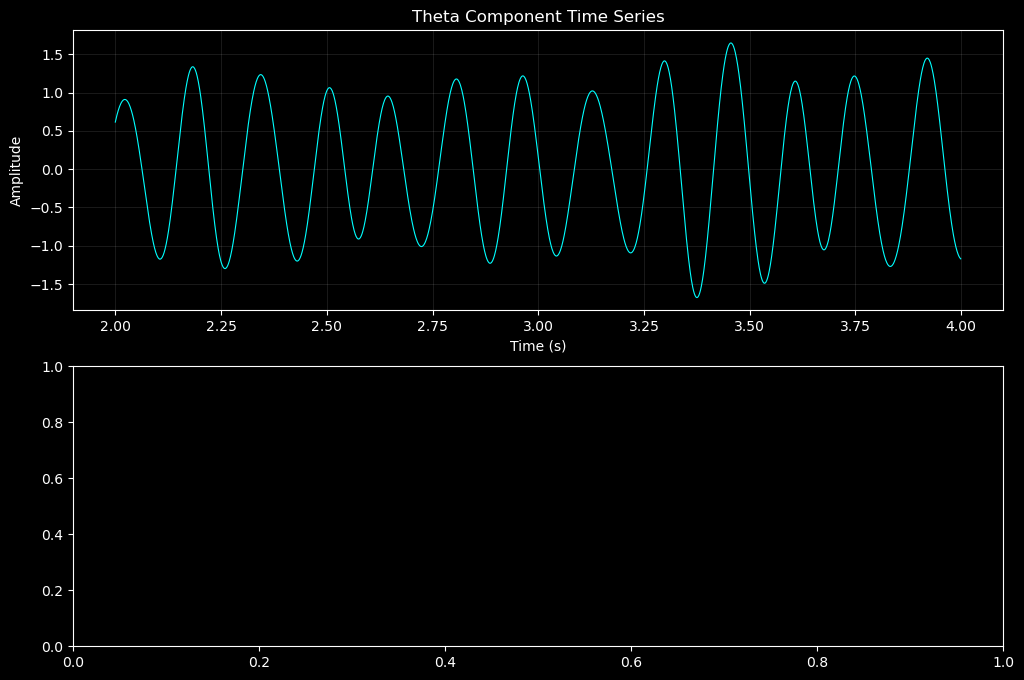

In [14]:
# Add visualization of results
import matplotlib.pyplot as plt

# Create time vector
times = np.arange(len(thetacomp)) / srate

# Plot in dark theme
plt.style.use('dark_background')

# Plot theta component time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), facecolor='black')

# Time series plot - show a segment
segment = slice(int(2*srate), int(4*srate))  # 2-second segment
ax1.plot(times[segment], thetacomp[segment], color='cyan', linewidth=0.8)
ax1.set_title('Theta Component Time Series')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.1)

# Topography
raw.info.set_montage('standard_1020')  # Set standard montage for plotting
mne.viz.plot_topomap(thetamap, raw.info, axes=ax2, show=False)
ax2.set_title('Theta Component Topography')

plt.tight_layout()
plt.show()

JUST PLOT TIME SERIES

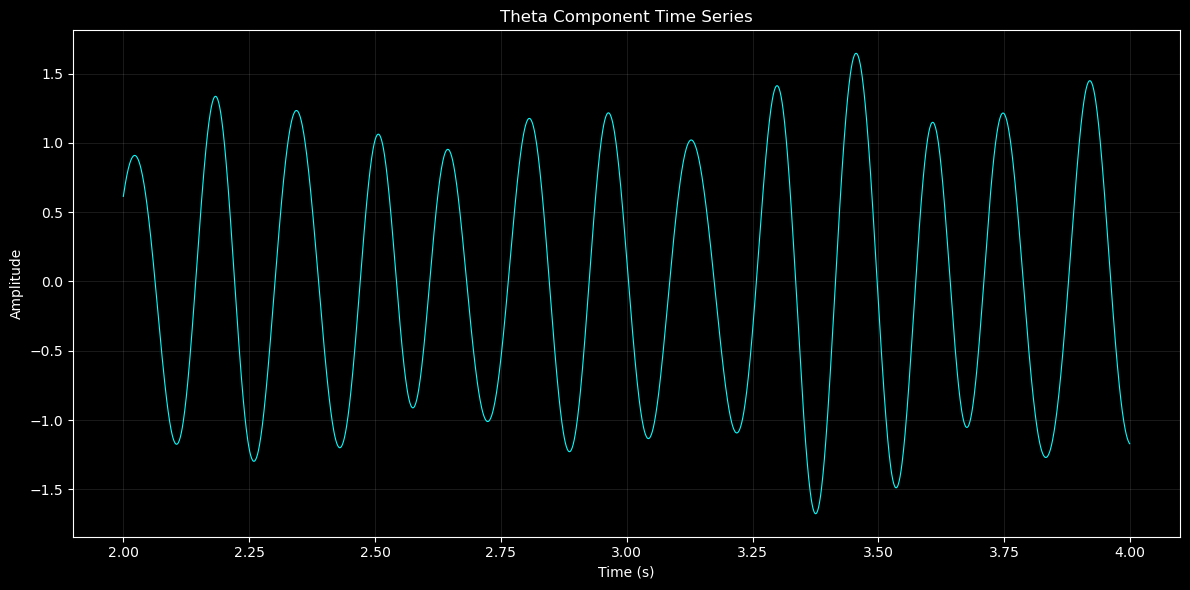


=== Component Statistics ===
Theta component mean: 0.000
Theta component std: 0.842
Theta component range: -1.676 to 1.649


In [15]:
# Plot results with just time series
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6), facecolor='black')

# Time series plot - show a 2-second segment
segment = slice(int(2*srate), int(4*srate))
ax.plot(times[segment], thetacomp[segment], color='cyan', linewidth=0.8)
ax.set_title('Theta Component Time Series')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid(True, alpha=0.1)
ax.set_facecolor('black')

# Adjust the spines
for spine in ax.spines.values():
    spine.set_color('white')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')

plt.tight_layout()
plt.show()

# Print some additional verification stats
print("\n=== Component Statistics ===")
print(f"Theta component mean: {np.mean(thetacomp):.3f}")
print(f"Theta component std: {np.std(thetacomp):.3f}")
print(f"Theta component range: {np.min(thetacomp):.3f} to {np.max(thetacomp):.3f}")

In [ ]:
IDENTIFYING THROUGHS AND COMPUTING PAC

In [16]:
# Identify troughs and get surrounding covariance matrices
nwin = int(np.ceil(srate/theta_freq/8))  # window size is 1/4 cycle (1/8 of either side)

# Find troughs (similar to MATLAB's diff(sign(diff())))
diff1 = np.diff(thetacomp)
diff2 = np.diff(np.sign(diff1))
troughs = np.where(diff2 > 0)[0] + 1

# Remove troughs too close to edges
troughs = troughs[(troughs > nwin) & (troughs < len(thetacomp) - nwin - 1)]

# Compute trough-locked covariance
covT = np.zeros((data.shape[0], data.shape[0]))  # channels x channels

# Accumulate covariance matrices around troughs
for trough in troughs:
    temp_data = data[:, trough-nwin:trough+nwin]
    temp_data = temp_data - np.mean(temp_data, axis=1, keepdims=True)
    covT += (temp_data @ temp_data.T) / (2*nwin)

covT = covT / len(troughs)

print("=== Trough Analysis ===")
print(f"Number of detected troughs: {len(troughs)}")
print(f"Window size around troughs: {nwin} samples")
print(f"Covariance matrix shape: {covT.shape}")

=== Trough Analysis ===
Number of detected troughs: 61
Window size around troughs: 22 samples
Covariance matrix shape: (64, 64)


In [ ]:
VISUALIZING WITH MNE

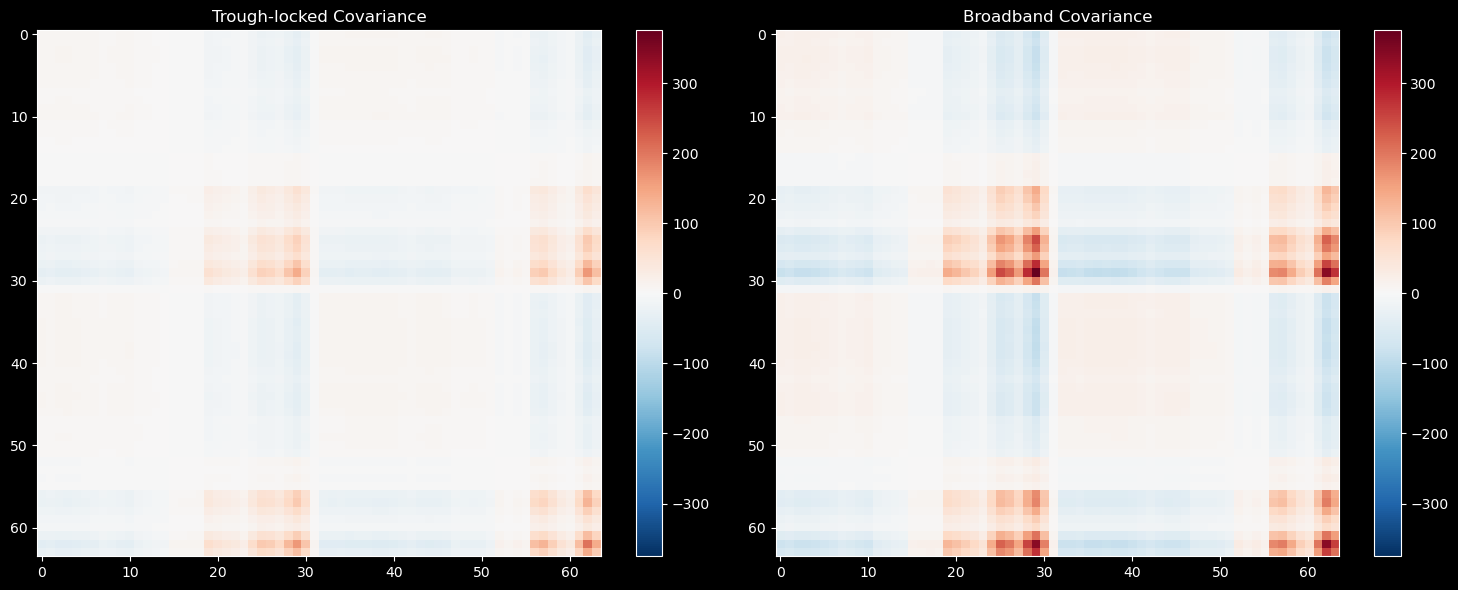


=== Covariance Matrix Properties ===
Trough-locked covariance range: -47.716 to 203.003
Broadband covariance range: -91.337 to 375.318


In [17]:
# Fix covariance matrix computations first
tmpdat = data - np.mean(data, axis=1, keepdims=True)
bbcov = np.array((tmpdat @ tmpdat.T) / data.shape[1], dtype=float)

# Now visualize
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='black')

# Plot trough-locked covariance
vmax = np.max([np.abs(covT).max(), np.abs(bbcov).max()])  # Same scale for both plots
im1 = ax1.imshow(covT, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
ax1.set_title('Trough-locked Covariance')
plt.colorbar(im1, ax=ax1)

# Plot broadband covariance for comparison
im2 = ax2.imshow(bbcov, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
ax2.set_title('Broadband Covariance')
plt.colorbar(im2, ax=ax2)

# Adjust appearance
for ax in [ax1, ax2]:
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Covariance Matrix Properties ===")
print(f"Trough-locked covariance range: {np.min(covT):.3f} to {np.max(covT):.3f}")
print(f"Broadband covariance range: {np.min(bbcov):.3f} to {np.max(bbcov):.3f}")

VERSION MATLAB 1 to 1

In [26]:
# MATLAB-matching trough detection
nwin = int(np.ceil(srate/theta_freq/8))  # same window calculation

# Find troughs exactly as MATLAB does
diff1 = np.diff(thetacomp)
diff2 = np.diff(np.sign(diff1))
troughs = np.where(diff2 > 0)[0] + 1

# Remove edge troughs exactly as MATLAB
troughs = troughs[(troughs > nwin) & (troughs < n_timepoints - nwin - 1)]

# Compute trough-locked covariance exactly as MATLAB
covT = np.zeros((data.shape[0], data.shape[0]))
for ti, trough in enumerate(troughs, 1):  # start enumeration from 1 to match MATLAB
    tmpdat = data[:, trough-nwin:trough+nwin]
    tmpdat = tmpdat - np.mean(tmpdat, axis=1, keepdims=True)
    covT += (tmpdat @ tmpdat.T)/nwin

covT = covT/len(troughs)  # MATLAB uses ti which equals length(troughs)

# Print comparison info
print("=== Trough Detection Verification ===")
print(f"Number of detected troughs: {len(troughs)}")
print(f"First few troughs: {troughs[:5]}")
print(f"Window size (nwin): {nwin}")

NameError: name 'n_timepoints' is not defined

In [ ]:
VERIFY

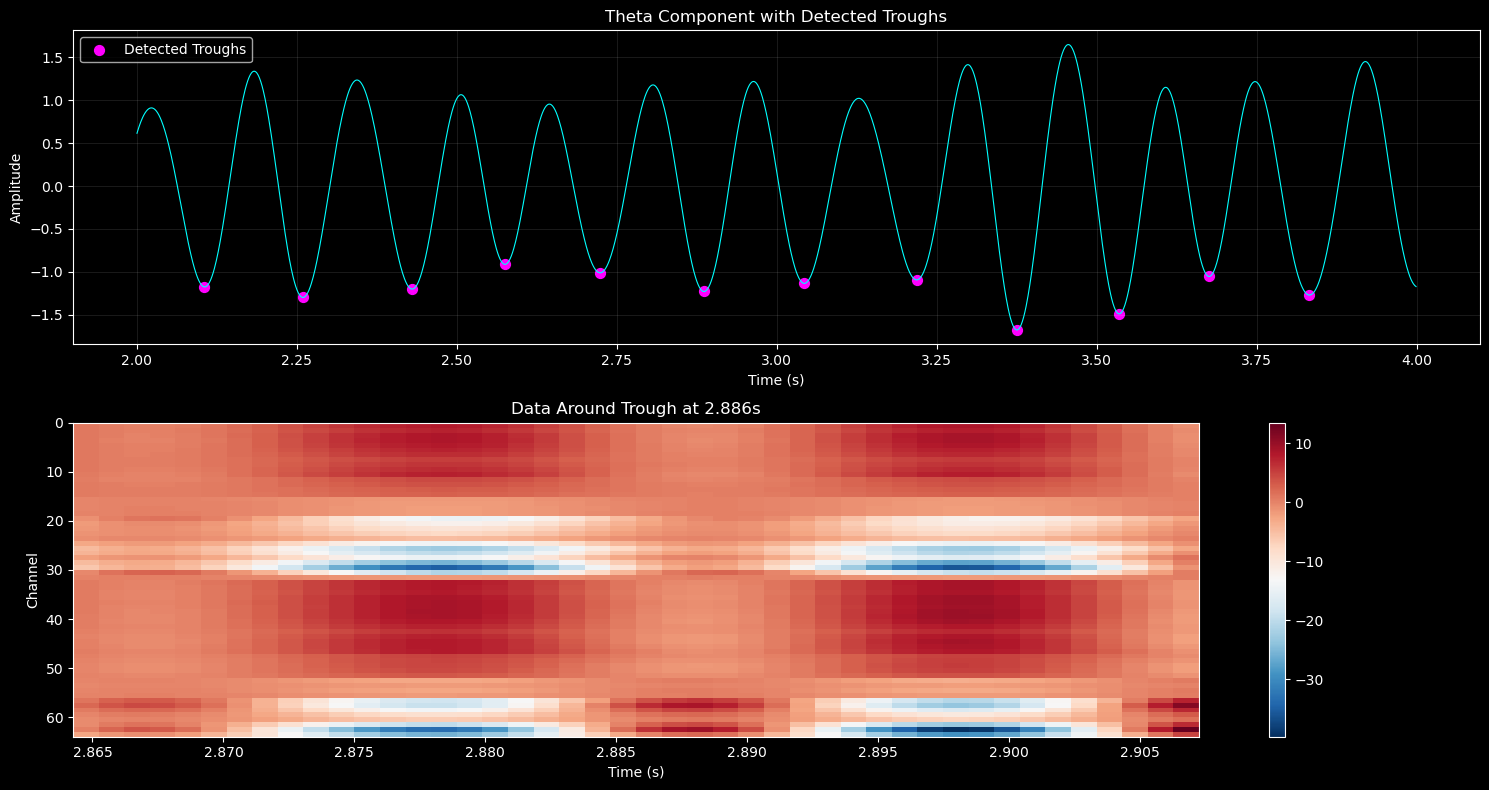


=== Trough Window Statistics ===
Window duration: 43.0 ms
Average time between troughs: 163.9 ms


In [20]:
# Create comprehensive visualization
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), facecolor='black')

# Plot 1: Theta component with marked troughs
segment = slice(int(2*srate), int(4*srate))  # 2-second segment
ax1.plot(times[segment], thetacomp[segment], color='cyan', linewidth=0.8)

# Mark troughs in the segment
troughs_in_segment = troughs[(troughs >= segment.start) & (troughs < segment.stop)]
ax1.scatter(times[troughs_in_segment], 
           thetacomp[troughs_in_segment], 
           color='magenta', 
           s=50, 
           label='Detected Troughs')

ax1.set_title('Theta Component with Detected Troughs')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.1)
ax1.legend()

# Plot 2: Example of data around one trough
example_trough = troughs_in_segment[5]  # take 5th trough in segment
trough_data = data[:, example_trough-nwin:example_trough+nwin]
im = ax2.imshow(trough_data, 
                aspect='auto', 
                cmap='RdBu_r',
                extent=[times[example_trough-nwin], times[example_trough+nwin], 
                       data.shape[0], 0])
ax2.set_title(f'Data Around Trough at {times[example_trough]:.3f}s')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Channel')
plt.colorbar(im, ax=ax2)

# Adjust appearance for dark theme
for ax in [ax1, ax2]:
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')

plt.tight_layout()
plt.show()

# Print some statistics about the trough windows
print("\n=== Trough Window Statistics ===")
print(f"Window duration: {2*nwin/srate*1000:.1f} ms")
print(f"Average time between troughs: {np.mean(np.diff(times[troughs]))*1000:.1f} ms")

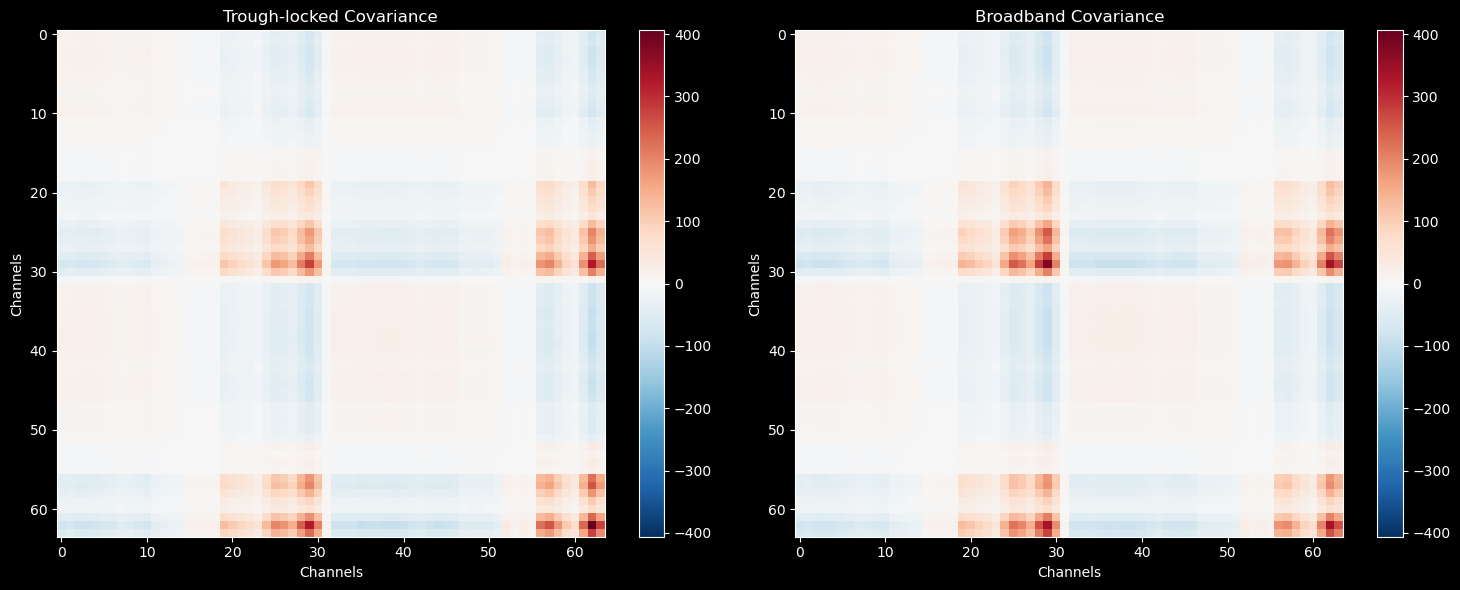


=== Covariance Matrix Properties ===
Trough-locked range: -95.431 to 406.006
Broadband range: -91.337 to 375.318


In [19]:
# Visualize both covariance matrices
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='black')

# Set symmetric limits for better comparison
vmax = max(np.abs(covT).max(), np.abs(bbcov).max())
vmin = -vmax

# Plot trough-locked covariance
im1 = ax1.imshow(covT, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_title('Trough-locked Covariance')
plt.colorbar(im1, ax=ax1)
ax1.set_xlabel('Channels')
ax1.set_ylabel('Channels')

# Plot broadband covariance
im2 = ax2.imshow(bbcov, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_title('Broadband Covariance')
plt.colorbar(im2, ax=ax2)
ax2.set_xlabel('Channels')
ax2.set_ylabel('Channels')

# Adjust dark theme
for ax in [ax1, ax2]:
   ax.set_facecolor('black')
   ax.tick_params(colors='white')
   ax.xaxis.label.set_color('white')
   ax.yaxis.label.set_color('white')
   ax.title.set_color('white')
   for spine in ax.spines.values():
       spine.set_color('white')

plt.tight_layout()
plt.show()

print("\n=== Covariance Matrix Properties ===")
print(f"Trough-locked range: {np.min(covT):.3f} to {np.max(covT):.3f}")
print(f"Broadband range: {np.min(bbcov):.3f} to {np.max(bbcov):.3f}")

In [21]:
# GED for PAC
# Regularize covariance matrices first
covT_reg = regularize_cov(covT)
bbcov_reg = regularize_cov(bbcov)

# GED for PAC
evals_pac, evecs_pac = linalg.eigh(covT_reg, bbcov_reg)

# Find best component and compute filter projection
maxcomp_pac = np.argsort(evals_pac)  # Get indices of sorted eigenvalues
pac_map = covT @ evecs_pac  # Forward model using original (non-regularized) covariance
pac_map = pac_map[:, maxcomp_pac[-1]]  # Take component with largest eigenvalue

# Get PAC time series
pac_ts = data.T @ evecs_pac[:, maxcomp_pac[-1]]

# Print some verification info
print("=== PAC Analysis ===")
print(f"Number of components: {len(evals_pac)}")
print(f"Eigenvalue range: {evals_pac.min():.3f} to {evals_pac.max():.3f}")
print(f"PAC time series shape: {pac_ts.shape}")

=== PAC Analysis ===
Number of components: 64
Eigenvalue range: 0.156 to 1.850
PAC time series shape: (10241,)


GED FOR GAMMA NETWORKS

In [22]:
def filterFGx(data, srate, center_freq, half_width):
    """
    Filter data around center frequency with specified bandwidth
    """
    nyq = srate/2
    
    # Calculate filter frequencies
    lower_freq = max(0.001, center_freq - half_width)  # Ensure positive frequency
    upper_freq = min(nyq - 0.001, center_freq + half_width)  # Ensure below Nyquist
    
    # Normalize frequencies
    wn = np.array([lower_freq, upper_freq]) / nyq
    
    # Create and apply filter
    b, a = signal.butter(2, wn, btype='band')
    return signal.filtfilt(b, a, data)

# Now run the frequency analysis again
frex = np.linspace(10, 190, 70)  # Frequency range to examine
mvarpac = np.zeros(len(frex))

# Loop through frequencies
for fi, freq in enumerate(frex):
    # Bandpass filter trough component
    gam1comp = filterFGx(data, srate, freq, 15).T @ evecs_pac[:, compidx[-1]]
    
    # Find peaks and troughs
    diff1 = np.diff(gam1comp)
    troughs = np.where(np.diff(np.sign(diff1)) > 0)[0] + 1
    peaks = np.where(np.diff(np.sign(diff1)) < 0)[0] + 1
    
    # Calculate mean peak-trough difference
    mvarpac[fi] = np.mean(gam1comp[peaks]) - np.mean(gam1comp[troughs])

# Plot results with dark theme
plt.style.use('dark_background')
plt.figure(figsize=(10, 5), facecolor='black')
plt.plot(frex, mvarpac, color='cyan', linewidth=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Peak-trough difference')
plt.title('Frequency-specific modulation')
plt.grid(True, alpha=0.1)
plt.show()

NameError: name 'compidx' is not defined

In [ ]:
GET PAC VALUE

In [24]:
# Get PAC value from the gamma band peak (around 40-50 Hz)
gamma_band_idx = np.logical_and(frex >= 35, frex <= 55)
pac_value = np.max(mvarpac[gamma_band_idx])

print("Original PAC value:", pac_value)

Original PAC value: 0.0


Frequency range: [36.08695652 38.69565217 41.30434783 43.91304348 46.52173913 49.13043478
 51.73913043 54.34782609]
PAC values in gamma band: [0. 0. 0. 0. 0. 0. 0. 0.]


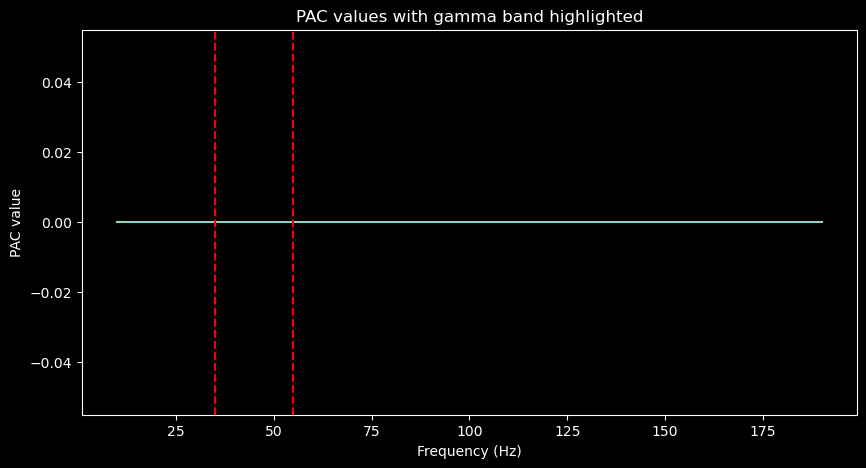


Frequency range (30, 60):
Max PAC value: 0.000

Frequency range (35, 55):
Max PAC value: 0.000

Frequency range (40, 60):
Max PAC value: 0.000


In [25]:
# Debug PAC values in gamma band
print("Frequency range:", frex[gamma_band_idx])
print("PAC values in gamma band:", mvarpac[gamma_band_idx])

# Plot full mvarpac again to verify
plt.figure(figsize=(10, 5))
plt.plot(frex, mvarpac)
plt.axvline(x=35, color='r', linestyle='--')
plt.axvline(x=55, color='r', linestyle='--')
plt.title('PAC values with gamma band highlighted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PAC value')
plt.show()

# Try different frequency ranges
for freq_range in [(30,60), (35,55), (40,60)]:
    mask = np.logical_and(frex >= freq_range[0], frex <= freq_range[1])
    print(f"\nFrequency range {freq_range}:")
    print(f"Max PAC value: {np.max(mvarpac[mask]):.3f}")